In [1]:
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import matplotlib.pyplot as plt

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
    ret = 0
    for i in range(len(u)):
        ret = ret + abs(u[i]-v[i])
    return ret

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0,
                                       high = num_dimensions,
                                       size = k)
        thresholds = np.random.randint(low = min_threshold,
                                       high = max_threshold + 1,
                                       size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 3):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)

    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors = 3):
    distances = map(lambda r: (r, l1(A[r], A[query_index])), filter(lambda i:i!=query_index,range(len(A))) )
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    return [t[0] for t in best_neighbors]

# TODO: Write a function that computes the error measure
def calerror(A,lsh_best_neighbors,line_best_neighbors,query_index):
    fz = sum( map(lambda r: l1(A[r], A[query_index]), lsh_best_neighbors) )
    fm = sum( map(lambda r: l1(A[r], A[query_index]), line_best_neighbors) )
    return fz/fm
    

In [2]:
A = load_data("data/patches.csv")

In [3]:
#对与第 100,200,...,1000 列中的图像块，分别使用 LSH 和线性搜索找出它们的前 3 近邻（这些图像块自身除外）。
#这两种方法的平均搜索用时是多少？
line_best_neighbors = []

lsh_start = time.time()
functions, hashed_A = lsh_setup(A)
for r in [100,200,300,400,500,600,700,800,900,1000]:
    lsh_best_neighbors = lsh_search(A, hashed_A, functions, r)
lsh_end = time.time()

line_start = time.time()
for r in [100,200,300,400,500,600,700,800,900,1000]:
    line_best_neighbors.append(linear_search(A, r))
line_end = time.time()

print("lsh 平均搜索用时：",(lsh_end-lsh_start)/10)
print("线性搜索 平均搜索用时：",(line_end-line_start)/10)

lsh 平均搜索用时： 1.8248265027999877
线性搜索 平均搜索用时： 8.27710964679718


c:\users\xxiao\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


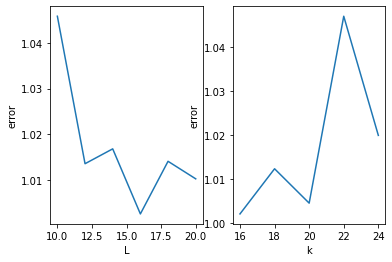

In [10]:
fig=plt.figure()
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

#将误差值绘制为关于 L 的函数 (取 L = 10, 12, 14, . . . , 20，此时固定 k = 24)。
errors = []
for L in [10,12,14,16,18,20]:
    error = 0
    functions, hashed_A = lsh_setup(A,24,L)
    for r in [100,200,300,400,500,600,700,800,900,1000]:
        lsh_best_neighbors = lsh_search(A, hashed_A, functions, r)
        error += calerror(A,lsh_best_neighbors,line_best_neighbors[r//100-1],r)
    error /= 10
    errors.append(error)
    #print("L=",L,", error=",error)
ax1.plot([10,12,14,16,18,20],errors)
ax1.set_xlabel('L')
ax1.set_ylabel('error')

# 将误差绘制为关于 k 的函数 (取 k = 16, 18, 20, 22, 24，此时固定 L = 10)
errors  = []
for k in [16,18,20,22,24]:
    error = 0
    functions, hashed_A = lsh_setup(A,k,10)
    for r in [100,200,300,400,500,600,700,800,900,1000]:
        lsh_best_neighbors = lsh_search(A, hashed_A, functions, r)
        error += calerror(A,lsh_best_neighbors,line_best_neighbors[r//100-1],r)
    error /= 10
    errors.append(error)
    #print("k=",k,", error=",error)
ax2.plot([16,18,20,22,24],errors)
ax2.set_xlabel('k')
ax2.set_ylabel('error')

fig.show()

In [11]:
# 画出两种方法找出的 10 个最近邻（包括原图本身），以及简要的视觉比较描述
functions, hashed_A = lsh_setup(A)
lsh_neighbors = lsh_search(A, hashed_A, functions, 100, 10)
line_neighbors = linear_search(A, 100, 10)
plot(A, lsh_neighbors, 'lsh')
plot(A, line_neighbors, 'line')